In [3]:
import torch
# import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from scipy.io import savemat, loadmat
from tqdm import tqdm
from torch.nn import DataParallel
import csv
from numba import njit, jit
import pandas as pd
import os
from scipy.special import rel_entr
from sklearn.metrics import mutual_info_score
# import seaborn as sn


In [4]:
def entropy(p):
    """Calculate entropy for given probability distribution."""
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def mutual_information(x, y, bins=120):
    """Estimate mutual information for continuous variables."""
    c_xy = np.histogram2d(x, y, bins)[0]
    p_xy = c_xy / np.sum(c_xy)  # Joint probability distribution
    p_x = np.sum(p_xy, axis=1)  # Marginal for x
    p_y = np.sum(p_xy, axis=0)  # Marginal for y
    
    # Calculate entropies
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_xy = entropy(p_xy.flatten())
    
    # Mutual information
    mi = h_x + h_y - h_xy
    return mi


def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [3]:
# header = ['epoch', 'channel','value']
# name = "ce"
# folder_header = "/home/sarvagya/Desktop/BCH/"+name+"/"
# csv_file = "data_"+name+".csv"
# temp_mat = "tempmatrix_"+name+".mat"
# with open(folder_header+csv_file, 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
    
uae_data = {
    "sub":[],
    "ses": [],
    "image": [],
    "UAE":[],
    "energy_map":[]
}
# print(torch.cuda.get_device_name(0))

In [ ]:
img_list = []
folder = "/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/THS_images"
subs = sorted(os.listdir(folder))
# for sub in subs:
#     sessions = sorted([ses for ses in os.listdir(folder+sub+'/') if "ses-" in ses])
#     for ses in sessions:

# print(img_list)
print(subs)

In [1]:
files_images = []
for root, dirs, files in os.walk(os.path.abspath(folder)):
    for file in files:
        files_images.append(os.path.join(root, file))
print(len(files_images))

In [2]:
# img = plt.imread("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/images/BSL-002/ses-03/axial/"+img_list[90])
# print(img[:,:,0:3].shape)
# plt.imshow(img[:,:,0:3])


In [8]:
# plt.imshow(img)

In [9]:
def energy_map(f_map):
  map = np.zeros((f_map.shape[1], f_map.shape[2]))
  for i in range(f_map.shape[0]):
    map = map + f_map[i]
  map = map/f_map.shape[0]
  return map

@jit
def uae(f_map):
  f_map = f_map[0]
  value=0
  value+=np.sum(f_map)
  return value/(f_map.shape[0]*f_map.shape[1]*f_map.shape[2])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16',pretrained=True)
# model = model.

In [ ]:
layers = [2,4,7,9,12,14,16,19,21,23,26,28,30]
value = []
idx = []
e_map = []
count = 0
for i in tqdm(range(len(subs))):
  # for j in range(channel):
    # img = mat['newmatrix'][i,j,:,:,:]
  sub = subs[i]
  sessions = sorted([ses for ses in os.listdir(folder+'/'+sub+'/') if "ses-" in ses])
  for ses in sessions:
    image_list = sorted(os.listdir(folder+'/'+sub+'/'+ses+'/axial'))
    for img_list in image_list:
      img = plt.imread(folder+'/'+sub+'/'+ses+'/axial/'+img_list)
      # print(img.shape)
      img = img[:,:,0:3]
      # img = np.rot90(img)
      img = img.reshape(-1,img.shape[2],img.shape[0],img.shape[1])
      # print(img.shape)
      img = torch.tensor(img, dtype=torch.float32)

      for k in layers:
        model_test = torch.nn.Sequential(*list(model.children())[0][:k])
          # model_test = DataParallel(model_test, device_ids=[0, 1])
          # print(model_test.device_ids)
          # img = img.cuda()
        res = model_test(img)
        res = res.cpu().detach().numpy()
        # print(res.shape)
        # temp_uae = uae(res)
        value.append(uae(res))
        # idx.append(img_list[i])
        res = np.squeeze(res)
        res_energy = energy_map(res)
        e_map.append(res_energy)
          # matrix_feature[i,j,:,:] = res_energy
        # idx = [i,j,value]
        # with open(folder_header+csv_file, 'a') as f:
        #   writer = csv.writer(f)
        #   writer.writerow(idx)
        # value = []
        # idx = []
      uae_data["image"].append(img_list)
      uae_data["sub"].append(sub)
      uae_data["ses"].append(ses)
      uae_data["UAE"].append(value)
      uae_data["energy_map"].append(e_map)

      value = []
      e_map = []
    count+=1
    print(count)



THIS IS TO CREATE AVG MAT FILE FOR UAE VALUES

In [8]:
# savemat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/complete_uae_data.mat", uae_data)
# data_mat_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-01.mat")
# data_mat_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-02.mat")
# data_mat_pat_2_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-01.mat")
# data_mat_pat_2_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-02.mat")
# data_mat_pat_3_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-01.mat")
# data_mat_pat_3_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-02.mat")
uae_data = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/complete_uae_data.mat")
data_mat = uae_data

In [6]:
# uae_values_ses_1 = data_mat_ses_1["UAE"].squeeze()
# uae_values_ses_1 = np.round(uae_values_ses_1, decimals=4)

# uae_values_ses_2 = data_mat_ses_2["UAE"].squeeze()
# uae_values_ses_2 = np.round(uae_values_ses_2, decimals=4)

# uae_values_pat_1_ses_1 = data_mat_pat_2_ses_1["UAE"].squeeze()
# uae_values_pat_1_ses_1 = np.round(uae_values_pat_1_ses_1, decimals=4)

# uae_values_pat_1_ses_2 = data_mat_pat_2_ses_2["UAE"].squeeze()
# uae_values_pat_1_ses_2 = np.round(uae_values_pat_1_ses_2, decimals=4)

# uae_values_pat_2_ses_1 = data_mat_pat_3_ses_1["UAE"].squeeze()
# uae_values_pat_2_ses_1 = np.round(uae_values_pat_2_ses_1, decimals=4)

# uae_values_pat_2_ses_2 = data_mat_pat_3_ses_2["UAE"].squeeze()
# uae_values_pat_2_ses_2 = np.round(uae_values_pat_2_ses_2, decimals=4)
# print(np.unique(uae_data["UAE"]))
print(len(uae_data["UAE"]))
uae_data["UAE"] = np.array(uae_data["UAE"])
uae_data["UAE"].reshape(len(uae_data["UAE"]), 13)
print(uae_data["UAE"].shape)

1992
(1992, 13)


In [9]:
matrices = {}
for sub in np.unique(uae_data["sub"]):
    print(sub)
    idx_sub = np.where(np.array(uae_data["sub"]) == sub)[0]
    print(idx_sub[0], idx_sub[-1])
    sessions = np.unique(uae_data["ses"][idx_sub[0]:idx_sub[-1]+1])
    print(sessions)
    new_dict_for_each_sub = {key: values[idx_sub[0]:idx_sub[-1]+1] for key, values in data_mat.items()}

    for ses in sessions:

        idx_ses = np.where(np.array(new_dict_for_each_sub["ses"]) == ses)[0]

        new_dict_for_each_ses_for_above_sub = {key: values[idx_ses[0]:idx_ses[-1]+1] for key, values in new_dict_for_each_sub.items()}

        exec(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]+" = []")
        print(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1])

        # exec(sub.split("-")[0]+ses.split("-")[0]+"_"+ses.split("-")[1]+".append()")

        print(new_dict_for_each_ses_for_above_sub["UAE"].shape)
        matrix_key = f'matrix_{sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]}'
        matrices[matrix_key] = new_dict_for_each_ses_for_above_sub["UAE"]


BSL-002
0 497
['ses-01' 'ses-02' 'ses-03']
BSL2ses_01
(166, 13)
BSL2ses_02
(166, 13)
BSL2ses_03
(166, 13)
NTL-004
498 995
['ses-01' 'ses-02' 'ses-03']
NTL4ses_01
(166, 13)
NTL4ses_02
(166, 13)
NTL4ses_03
(166, 13)
NTL-008
996 1493
['ses-01' 'ses-02' 'ses-03']
NTL8ses_01
(166, 13)
NTL8ses_02
(166, 13)
NTL8ses_03
(166, 13)
ZRH-004
1494 1991
['ses-01' 'ses-02' 'ses-03']
ZRH4ses_01
(166, 13)
ZRH4ses_02
(166, 13)
ZRH4ses_03
(166, 13)


In [10]:
matrix_sub = list(matrices.keys())
matrices_probability = {}

for i in range(len(matrix_sub)):

    print(matrix_sub[i])

    test_matrix = matrices[matrix_sub[i]]
    print(test_matrix.shape)

    uae_values_ses = np.round(test_matrix, decimals=4)
    print(uae_values_ses)
    print(uae_values_ses.shape)

    for i in range(test_matrix.shape[1]):

        print(uae_values_ses[:,i].shape)

        unique_ses, counts_ses = np.unique(uae_values_ses[:,i], return_counts=True)

        pdf_ses = counts_ses/counts_ses.shape[0]

        # print(pdf_ses)
        # print(pdf_ses.shape)

    # matrix_key = f'matrix_{matrix_sub[i]+"_probability"}'
    # matrices_probability[matrix_key] = 

matrix_BSL2ses_01
(166, 13)
[[0.1791 0.148  0.2987 ... 0.1496 0.086  0.0313]
 [0.1792 0.1485 0.3001 ... 0.1438 0.0922 0.0337]
 [0.1791 0.1476 0.2972 ... 0.1639 0.0893 0.0315]
 ...
 [0.1792 0.1474 0.2957 ... 0.1194 0.0692 0.0254]
 [0.1792 0.1475 0.296  ... 0.1222 0.0718 0.0266]
 [0.1792 0.1475 0.2961 ... 0.121  0.0695 0.0259]]
(166, 13)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
matrix_BSL2ses_02
(166, 13)
[[0.1791 0.148  0.2987 ... 0.1496 0.086  0.0313]
 [0.1792 0.1485 0.2998 ... 0.1425 0.0915 0.0333]
 [0.1791 0.1477 0.2974 ... 0.1651 0.0895 0.0317]
 ...
 [0.1792 0.1474 0.2957 ... 0.1194 0.0692 0.0254]
 [0.1792 0.1475 0.296  ... 0.1222 0.0718 0.0266]
 [0.1792 0.1475 0.2961 ... 0.121  0.0695 0.0259]]
(166, 13)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
(166,)
matrix_BSL2ses_03
(166, 13)
[[0.1792 0.148  0.2988 ... 0.1512 0.0872 0.0317]
 [0.1792 0.1484 0.2997 ... 0.1419 0.0909 0.0332]
 [0.1791 0.1477 

In [11]:
matrix_sub = list(matrices.keys())
num_matrices = 12
mi_matrix = np.zeros((num_matrices, num_matrices, 13))
print(matrix_sub)

for i in range(len(matrix_sub)):
    print(matrix_sub[i])
    for j in range(i, len(matrix_sub)):
        for k in range(13):
            mi = mutual_information(matrices[matrix_sub[i]][:,k], matrices[matrix_sub[j]][:,k], 1000)
            mi_matrix[i, j, k] = mi
            mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric



# print(temp_x)

['matrix_BSL2ses_01', 'matrix_BSL2ses_02', 'matrix_BSL2ses_03', 'matrix_NTL4ses_01', 'matrix_NTL4ses_02', 'matrix_NTL4ses_03', 'matrix_NTL8ses_01', 'matrix_NTL8ses_02', 'matrix_NTL8ses_03', 'matrix_ZRH4ses_01', 'matrix_ZRH4ses_02', 'matrix_ZRH4ses_03']
matrix_BSL2ses_01
matrix_BSL2ses_02
matrix_BSL2ses_03
matrix_NTL4ses_01
matrix_NTL4ses_02
matrix_NTL4ses_03
matrix_NTL8ses_01
matrix_NTL8ses_02
matrix_NTL8ses_03
matrix_ZRH4ses_01
matrix_ZRH4ses_02
matrix_ZRH4ses_03


In [ ]:
mi_matrix.shape

/tmp/ipykernel_882967/2290442301.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


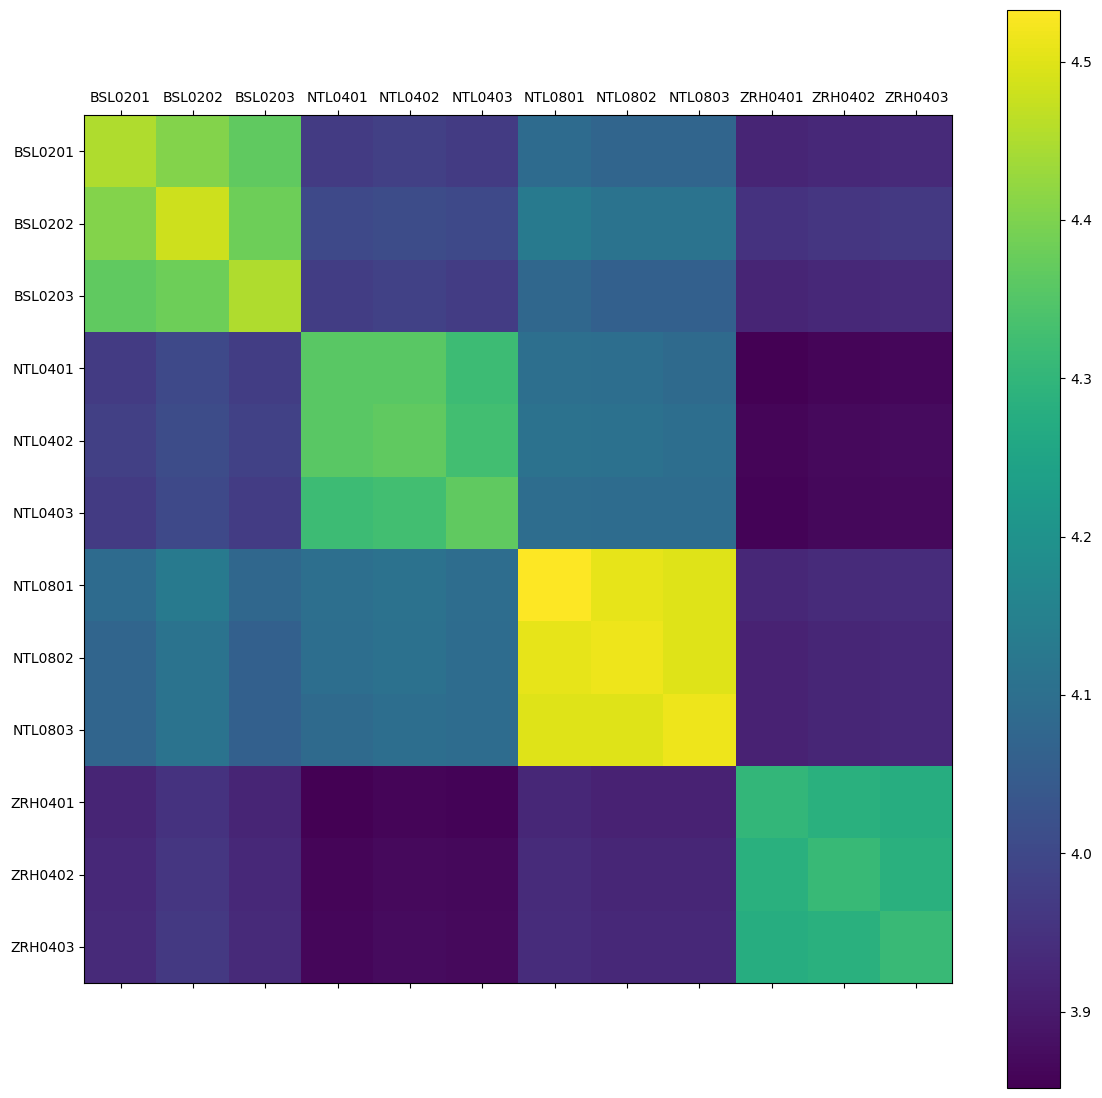

In [12]:
# plt.matshow(mi_matrix[:,:,12])


alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = mi_matrix[:,:,1]

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticklabels(alpha)
# ax.set_yticklabels(alpha)

ax.set_xticks(np.arange(len(alpha)), labels=alpha)
ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

(12, 12)


/tmp/ipykernel_882967/3468779582.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


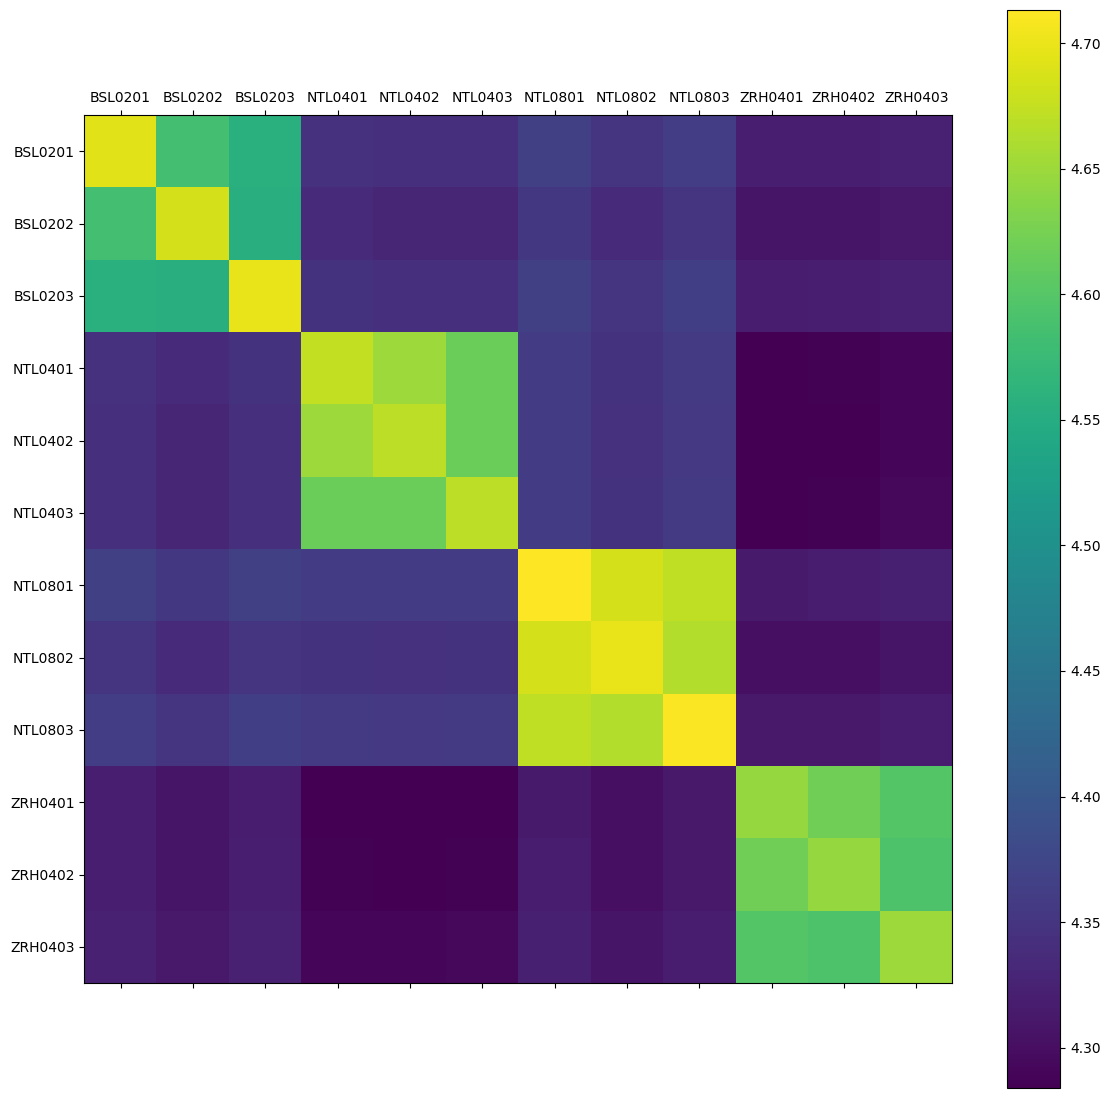

In [13]:
y = np.average(mi_matrix, axis=2)
print(y.shape)

alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = y

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(alpha)), labels=alpha)
ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

In [251]:
unique_ses_1, counts_ses_1 = np.unique(uae_values_ses_1, return_counts=True)
unique_ses_2, counts_ses_2 = np.unique(uae_values_ses_2, return_counts=True)
unique_pat_1_ses_1, counts_pat_1_ses_1 = np.unique(uae_values_pat_1_ses_1, return_counts=True)
unique_pat_1_ses_2, counts_pat_1_ses_2 = np.unique(uae_values_pat_1_ses_2, return_counts=True)

unique_pat_2_ses_1, counts_pat_2_ses_1 = np.unique(uae_values_pat_2_ses_1, return_counts=True)
unique_pat_2_ses_2, counts_pat_2_ses_2 = np.unique(uae_values_pat_2_ses_2, return_counts=True)

In [252]:
pdf_ses_1 = counts_ses_1/counts_ses_1.shape[0]
pdf_ses_2 = counts_ses_2/counts_ses_2.shape[0]
pdf_pat_1_ses_1 = counts_pat_1_ses_1/counts_pat_1_ses_1.shape[0]
pdf_pat_1_ses_2 = counts_pat_1_ses_2/counts_pat_1_ses_2.shape[0]

pdf_pat_2_ses_1 = counts_pat_2_ses_1/counts_pat_2_ses_1.shape[0]
pdf_pat_2_ses_2 = counts_pat_2_ses_2/counts_pat_2_ses_2.shape[0]

In [ ]:
print("KL of session 1 and session 2: ", sum(rel_entr(pdf_ses_1, pdf_ses_2[1:])))
print("KL of session 2 and session 1: ", sum(rel_entr(pdf_ses_2[1:], pdf_ses_1)))
print("KL of session 1 and patient 2 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_1_ses_1[2:])))
print("KL of patient 2 session 1 and session 1: ", sum(rel_entr(pdf_pat_1_ses_1[2:], pdf_ses_1)))
print("KL of session 2 and patient 2 session 1: ", sum(rel_entr(pdf_ses_2, pdf_pat_1_ses_1[1:])))
print("KL of patient 2 session 1 and session 2: ", sum(rel_entr(pdf_pat_1_ses_1[1:], pdf_ses_2)))

print("KL of patient 2 session 1 and patient 2 session 2: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_1_ses_2[3:])))
print("KL of patient 2 session 2 and patient 2 session 1: ", sum(rel_entr(pdf_pat_1_ses_2[3:], pdf_pat_1_ses_1)))

print("KL of patient 3 session 1 and patient 3 session 2: ", sum(rel_entr(pdf_pat_2_ses_1, pdf_pat_2_ses_2[3:])))
print("KL of patient 3 session 2 and patient 3 session 1: ", sum(rel_entr(pdf_pat_2_ses_2[3:], pdf_pat_2_ses_1)))

print("KL of patient 3 session 1 and patient 1 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[4:], pdf_ses_1)))
print("KL of patient 1 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_2_ses_1[4:])))

print("KL of patient 3 session 1 and patient 2 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[2:], pdf_pat_1_ses_1)))
print("KL of patient 2 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_2_ses_1[2:])))

In [260]:
pat_0_ses = list(pdf_ses_1.flatten()) + list(pdf_ses_2.flatten())

pat_1_ses = list(pdf_pat_1_ses_1.flatten()) + list(pdf_pat_1_ses_2.flatten())

pat_2_ses = list(pdf_pat_2_ses_1.flatten()) + list(pdf_pat_2_ses_2.flatten())

In [ ]:
len(pat_0_ses)

In [ ]:
bins = np.linspace(0, 0.2, 10)

plt.hist(pat_0_ses, bins, label='x')
plt.hist(pat_1_ses, bins, label='y')
plt.hist(pat_2_ses, bins, label='z')
plt.legend(loc='upper right')
plt.show()

In [ ]:
max(pdf_pat_1_ses_1)

In [ ]:
x[:,0]